# The Simpsons
![The Simpsons](https://upload.wikimedia.org/wikipedia/ru/4/42/Simpsons_cast.jpg)

Import

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from PIL import Image

from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models

## Load data

In [2]:
train_dir = r'train\simpsons_dataset'
test_dir = r'testset\testset'
rescale_size = 244
batch_size = 32 # 32 - resnet152. 64 - all another
# Imagenet mean and standard (are calculated from all of images)
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [3]:
dataset = datasets.ImageFolder(root=train_dir)
print(f'Number per classes: \n\t{dict(Counter(dataset.targets))}')
#number of classes
dataset_classes_num = len(dataset.classes)
dataset_classes = np.array(dataset.classes)
print(f'num classes = {dataset_classes_num}')

Number per classes: 
	{0: 913, 1: 42, 2: 623, 3: 106, 4: 1342, 5: 98, 6: 1193, 7: 986, 8: 47, 9: 469, 10: 8, 11: 457, 12: 27, 13: 27, 14: 121, 15: 2246, 16: 498, 17: 1206, 18: 310, 19: 3, 20: 1354, 21: 128, 22: 1291, 23: 71, 24: 246, 25: 1079, 26: 17, 27: 1452, 28: 1454, 29: 358, 30: 32, 31: 72, 32: 1194, 33: 65, 34: 45, 35: 89, 36: 103, 37: 877, 38: 40, 39: 55, 40: 8, 41: 181}
num classes = 42


Class very imbalanced, so we will use WeightedRandomSampler to solve it. <br>
In this way, we calc weight for each class, instead use shuffle. It can improve balance in batches<br>
After i made this, i saw, that this isn't make any sense for fit and inference. But, let it slide)
<br> <br>
If you want to use shuffle, replace row 'sampler = sampler,' in dalaloader to 'shuffle=True,' 

In [4]:
# split data to train and valid
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, 
                                                     [round(len(dataset)*.85), 
                                                      round(len(dataset)*.15)]
                                                    )
# get index
y_train_indices = dataset_train.indices
dataset_size = {'train' : len(dataset_train),
                'valid' : len(dataset_valid),
                }

# get target for per index
y_train = [dataset.targets[i] for i in y_train_indices]
# calc count of values for each class
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
# get weight per class
weight = 1. / class_sample_count
# get weight per sample (by index)
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# make sampler object
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

Add transform
Resize - reduce original size of image to input size
Random crop - take random part of image with scale
Flip - just flip
Blur - can reduce noise
affine - rotate and shift
normalize - notmalize by weight

In [5]:
transform = {
    "train": tfs.Compose(
        [
            tfs.Resize(size=(224, 224)), # 224px - input size for mobilenet v3
            tfs.RandomCrop(224*0.7),
            tfs.RandomHorizontalFlip(p=0.5),
            tfs.RandomVerticalFlip(p=0.05),
            tfs.GaussianBlur(kernel_size=5, sigma=(3e-4, 5)),
            tfs.RandomAffine(degrees=(-10, 10), # rotate
                             shear = (-5, 5, -5, 5), # shift
                             ),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": tfs.Compose( 
        [
            tfs.Resize(size=(224, 224)),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

Make class for application transformer <br>
Not nessesery... May be, use before sklearn random_split would be a great idea

In [6]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

Well, we are ready to load data to loader!

In [7]:
dataset_train.dataset.transform = transform['train'] # doesn't work for my
dataset_valid.dataset.transform = transform['valid'] # doesn't work for my

# dataset_train = MyDataset(dataset_train, 
#                           transform = transform['train'])
# dataset_valid = MyDataset(dataset_valid, 
#                           transform = transform['valid'])

dataloaders = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset_train, 
        batch_size=batch_size, 
        sampler = sampler, 
        # num_workers=2
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset_valid, 
        batch_size=batch_size, 
        shuffle=False, 
        # num_workers=2
    ),
}

## Fit functions

In [8]:
def fit(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    scheduler: torch.nn.Module,
    epochs: int = 5
):
    
    losses = {'train': [], 'valid': []}
    accuracy = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch:', leave=False)
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))
            
            for inputs, labels in tqdm(dataloaders[phase], desc=f'Phase {phase}:', leave=False):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
            
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)
                
                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_accuracy.tolist())
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
    
    return losses, accuracy

Fit MobileNet V3

In [9]:
# get mobilenet v3
model = torchvision.models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
# define loss, optimizer and learning rate scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
for param in model.parameters():
    param.requires_grad = False

# Change the final layer of model for Transfer Learning
model.classifier[3] = nn.Linear(1024, dataset_classes_num)

# Train last layer
history = fit(model.to(DEVICE), 
              criterion = criterion, 
              optimizer = optimizer, 
              scheduler = scheduler,
              epochs = 1,
             )

# Unreeze all layer
for param in model.parameters():
    param.requires_grad = True

# Train all layer
history = fit(model.to(DEVICE), 
              criterion = criterion, 
              optimizer = optimizer, 
              scheduler = scheduler,
              epochs = 10
             )

Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

Phase train::   0%|          | 0/557 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/99 [00:00<?, ?it/s]

In [11]:
def show_metrics_all(losses, accuracy):
    def show_ax(ax_idx, metric, title):
        axes[ax_idx].plot(metric['train'], label='train')
        axes[ax_idx].plot(metric['valid'], label='valid')
        axes[ax_idx].grid()
        axes[ax_idx].legend()
        axes[ax_idx].set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6
                                            ))
    show_ax(0, metric = losses, title = 'loss')
    show_ax(1, metric = accuracy, title = 'accuracy')
    plt.show()

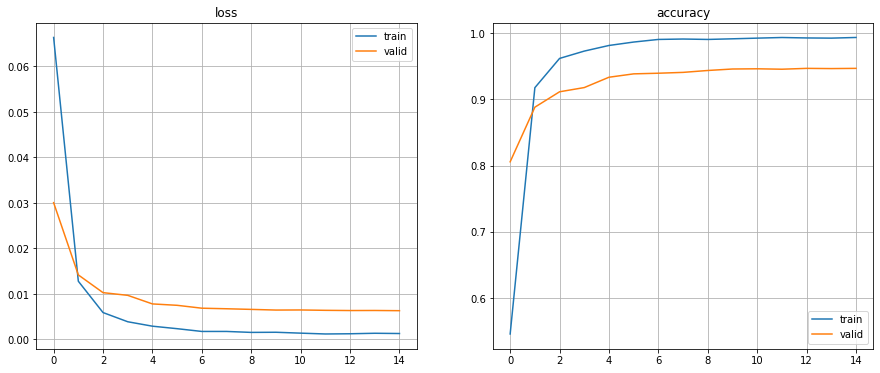

In [12]:
loss, accuracy = zip(history)
show_metrics_all(loss[0], accuracy[0])

## Test
First, make Dataloader for test data

In [13]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        transform = tfs.transforms.Compose([
            tfs.transforms.Resize(size=(224, 224)),
            tfs.transforms.ToTensor(),
            tfs.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return transform(img)
    
    def __len__(self):
        return len(self.files)
    
test_files = sorted(list(Path(test_dir).rglob('*.jpg')))

dataset_test = TestDataset(test_files)
dataloader_test = torch.utils.data.DataLoader(dataset_test, 
                                              shuffle=False, 
                                              batch_size=batch_size)

Make predict function

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

And make predict <br>
\\(^+^)/

In [15]:
probs = predict(model, dataloader_test)
preds = [dataset_classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in dataset_test.files]

pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("submission.csv", index=False)


In [16]:
from sklearn.metrics import f1_score

def make_f1_score(model, n=1000):
    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [dataset_valid[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [dataset_valid[id][1] for id in idxs]
    preds_class = list(y_pred)
    return f1_score(actual_labels, preds_class, average='micro')

make_f1_score(model) # on valid


0.957

On test data: <br><br>
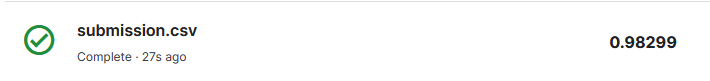